In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GuWDGlrF3GuWPUASY26M")
project = rf.workspace("deeplearningproject-7393p").project("ham10000-skin-lesions-annotation")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
dataset.location

'/content/ham10000-skin-lesions-annotation-1'

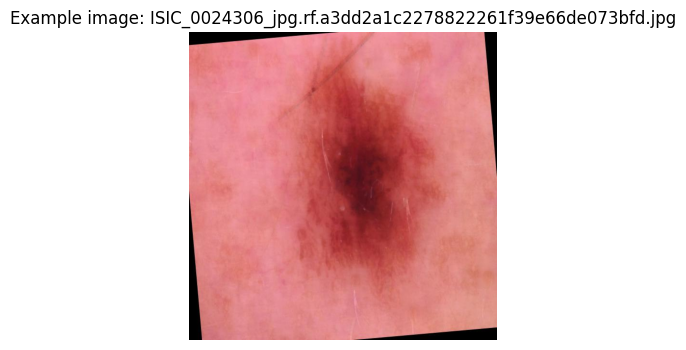

In [3]:
import cv2
import matplotlib.pyplot as plt
from roboflow import Roboflow

# Get the path to the images directory
images_path = dataset.location + "/train"

# Get a list of all image files in the directory
import os
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]

# Choose a random image
import random
random_image = random.choice(image_files)

# Read the image using OpenCV
img = cv2.imread(os.path.join(images_path, random_image))

# Convert BGR to RGB (OpenCV loads images in BGR format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Example image: {random_image}")
plt.show()

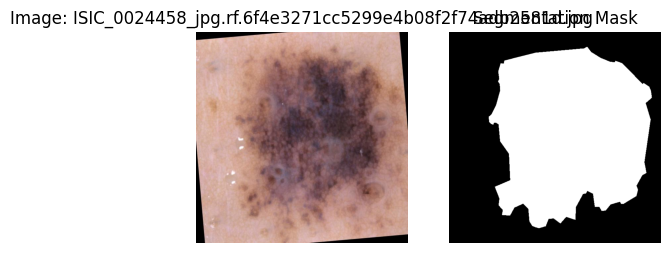

Image shape: (640, 640, 3)
Mask shape: (640, 640)
Mask dtype: uint8


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pycocotools import mask as mask_utils

# Load COCO annotations
with open('/content/ham10000-skin-lesions-annotation-1/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Choose a random image
import random
random_image = random.choice(coco_data['images'])
image_id = random_image['id']
image_filename = random_image['file_name']

# Load the image
img_path = f"/content/ham10000-skin-lesions-annotation-1/train/{image_filename}"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Find corresponding annotation
annotation = next((ann for ann in coco_data['annotations'] if ann['image_id'] == image_id), None)

if annotation:
    # Create mask from segmentation
    segmentation = annotation['segmentation'][0]  # Assuming polygon format
    rle = mask_utils.frPyObjects([segmentation], img.shape[0], img.shape[1])
    mask = mask_utils.decode(rle)
    mask = np.squeeze(mask)

    # Display the image and its mask
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Image: {image_filename}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Segmentation Mask")

    plt.show()
else:
    print(f"No annotation found for image: {image_filename}")

# Print debug information
print(f"Image shape: {img.shape if img is not None else 'N/A'}")
print(f"Mask shape: {mask.shape if 'mask' in locals() else 'N/A'}")
print(f"Mask dtype: {mask.dtype if 'mask' in locals() else 'N/A'}")

In [5]:
dataset

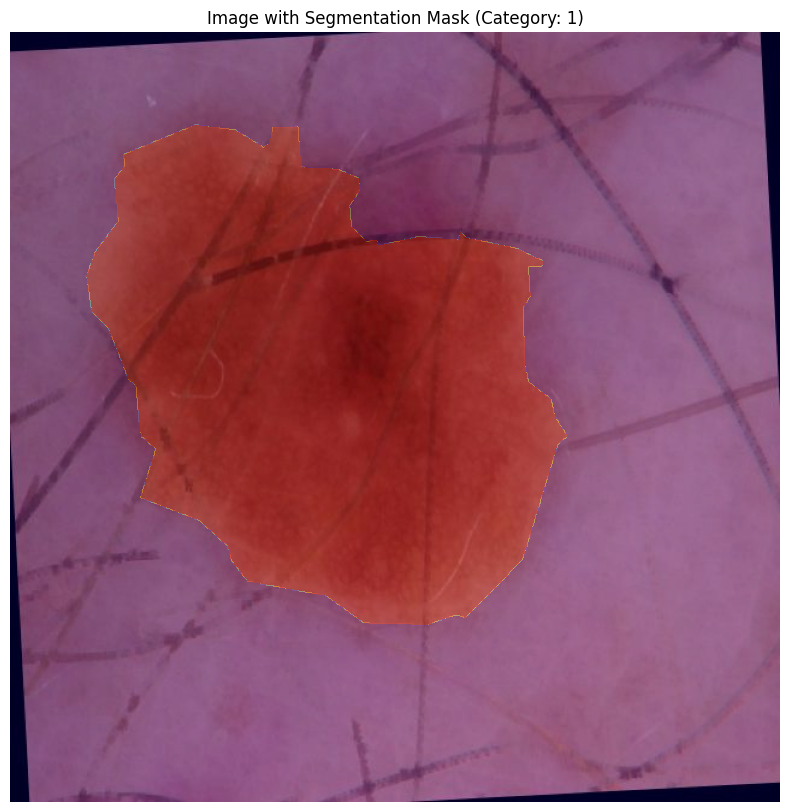

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pycocotools import mask as mask_utils
from skimage import draw


# Load COCO annotations
with open('/content/ham10000-skin-lesions-annotation-1/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Select an image (for this example, we'll use the first image)
image_info = coco_data['images'][0]
image_id = image_info['id']
file_name = image_info['file_name']

# Load the image
image_path = f"/content/ham10000-skin-lesions-annotation-1/train/{file_name}"
image = Image.open(image_path)

annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

def create_mask_from_polygon(segmentation, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for seg in segmentation:
        poly = np.array(seg).reshape((len(seg)//2, 2))
        rr, cc = draw.polygon(poly[:, 1], poly[:, 0])
        mask[rr, cc] = 1
    return mask.astype(bool)

# Use the first annotation for this example
annotation = annotations[0]
segmentation = annotation['segmentation']
mask = create_mask_from_polygon(segmentation, np.array(image).shape)

plt.figure(figsize=(10, 10))

# Display the original image
plt.imshow(image)

# Overlay the mask
plt.imshow(mask, alpha=0.3, cmap='jet')  # You can adjust alpha for transparency

plt.axis('off')
plt.title(f"Image with Segmentation Mask (Category: {annotation['category_id']})")
plt.show()

In [7]:
def get_bounding_box(segmentation):
    # Flatten the segmentation list
    flat_seg = [coord for segment in segmentation for coord in segment]

    # Separate x and y coordinates
    x_coords = flat_seg[0::2]
    y_coords = flat_seg[1::2]

    # Calculate bounding box
    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_coords)
    y_max = max(y_coords)

    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min

    # Round the values to 3 decimal places
    return [round(x_min, 3), round(y_min, 3), round(width, 3), round(height, 3)]

bbox = get_bounding_box(segmentation)
print(f"Segmentation: {segmentation}")
print(f"Bounding box [x_min, y_min, width, height]: {bbox}")

Segmentation: [[432.185, 218.701, 430.565, 194.575, 442.637, 193.942, 442.414, 189.681, 421.58, 179.38, 378.376, 170.251, 373.818, 164.793, 372.059, 172.006, 338.815, 169.476, 306.091, 176.887, 304.802, 172.682, 295.216, 173.185, 283.894, 160.961, 282.307, 151.075, 281.935, 143.973, 290.852, 130.688, 289.266, 120.802, 271.776, 113.174, 241.802, 111.896, 238.95, 77.866, 217.646, 78.982, 215.12, 91.932, 209.943, 95.052, 186.755, 80.601, 153.436, 76.65, 93.836, 101.137, 94.357, 111.078, 86.356, 121.467, 89.282, 156.918, 70.309, 182.123, 62.829, 202.454, 67.588, 232.112, 81.115, 245.645, 98.335, 288.892, 103.884, 292.873, 108.248, 335.37, 120.56, 346.118, 107.732, 386.667, 156.782, 405.459, 180.342, 427.011, 183.068, 438.262, 196.818, 456.056, 262.615, 468.273, 293.706, 490.855, 346.124, 492.38, 370.252, 483.995, 377.857, 486.445, 425.54, 438.372, 454.714, 342.848, 462.863, 335.3, 452.383, 318.759, 449.508, 304.668, 430.581, 289.994, 427.706, 275.903, 426.315, 228.978, 432.185, 218.701]]
B

In [8]:
dataset

In [9]:
from pycocotools.coco import COCO
coco = COCO('/content/ham10000-skin-lesions-annotation-1/train/_annotations.coco.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [10]:
coco.getAnnIds(list(coco.imgs.keys()))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [11]:
coco.loadImgs(569)[0]

{'id': 569,
 'license': 1,
 'file_name': 'ISIC_0024415_jpg.rf.aa782005b90ad238a44619bd61732d17.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2024-12-04T23:51:17+00:00'}

In [12]:
# Get annotation IDs for the specified image
ann_ids = coco.getAnnIds(imgIds=569)

# Load annotations for the image
annotations = coco.loadAnns(ann_ids)
annotations

[{'id': 569,
  'image_id': 569,
  'category_id': 1,
  'bbox': [0, 23, 605.867, 551.822],
  'area': 334330.69,
  'segmentation': [[0,
    179.2,
    6.4,
    210.489,
    10.667,
    280.178,
    6.4,
    281.6,
    7.467,
    302.933,
    58.667,
    344.178,
    88.533,
    409.6,
    114.133,
    426.667,
    155.733,
    486.4,
    195.2,
    502.044,
    225.067,
    503.467,
    294.4,
    543.289,
    308.267,
    543.289,
    353.067,
    570.311,
    371.2,
    574.578,
    389.333,
    571.733,
    525.867,
    510.578,
    531.2,
    514.844,
    540.8,
    503.467,
    544,
    480.711,
    574.933,
    388.267,
    600.533,
    339.911,
    605.867,
    302.933,
    603.733,
    271.644,
    586.667,
    253.156,
    581.333,
    233.244,
    585.6,
    217.6,
    582.4,
    203.378,
    563.2,
    186.311,
    561.067,
    177.778,
    555.733,
    177.778,
    535.467,
    139.378,
    535.467,
    116.622,
    525.867,
    98.133,
    460.8,
    54.044,
    384,
    44.0

In [13]:
list(coco.imgs.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [14]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from PIL import Image
import numpy as np

class HAM10000Dataset(Dataset):
    def __init__(self, coco_annotation_file, image_dir, transform=None):
        self.coco = COCO(coco_annotation_file)
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        image = Image.open(f"{self.image_dir}/{img_info['file_name']}").convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Create a binary mask for all annotations
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(self.coco.annToMask(ann), mask)

        # Convert mask to tensor
        #mask = torch.from_numpy(mask).float()

        # Convert mask to PIL Image
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = transforms.Compose([
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])(mask)

        # Convert image to tensor if not done by transform
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        # Create a bounding box prompt
        bbox = torch.tensor([ann['bbox'] for ann in anns]).float()

        return image, mask, bbox, img_id

In [15]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define your transforms
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # SAM typically uses 1024x1024 images
    transforms.ToTensor(),
])

# Create the dataset
dataset = HAM10000Dataset(
    coco_annotation_file='/content/ham10000-skin-lesions-annotation-1/train/_annotations.coco.json',
    image_dir='/content/ham10000-skin-lesions-annotation-1/train/',
    transform=transform
)

# Create the DataLoader
batch_size = 1  # Adjust based on your GPU memory
num_workers = 1  # Adjust based on your CPU cores
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [16]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/segment-anything.git
#!wget --output-document sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!wget --output-document sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
#https://archive.ph/Gus1g#selection-1175.0-1303.79
!pip install supervision

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5pj_qykj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5pj_qykj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [17]:
#from segment_anything import sam_model_registry
# Initialize SAM model
import torch
import cv2
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
MODEL_TYPE = ["vit_h","vit_l","vit_b"]
CHECKPOINT_PATH =["./sam_vit_h_4b8939.pth","sam_vit_l_0b3195.pth","sam_vit_b_01ec64.pth"]

model = "vit_b"
if model =='vit_h':
  CHECKPOINT_PATH = f"./sam_{model}_4b8939.pth"
elif model =='vit_l':
  CHECKPOINT_PATH = f"./sam_{model}_0b3195.pth"
else:
  CHECKPOINT_PATH = f"./sam_{model}_01ec64.pth"

sam = sam_model_registry[model](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

sam.image_encoder.img_size

cuda:0


1024

In [18]:
# Freeze encoder weights
for param in sam.image_encoder.parameters():
    param.requires_grad = False


In [19]:
import torch.nn.functional as F

num_epochs=5
# Set up optimizer (only for mask decoder)
optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    print("----------------------")
    print("eopoch: ",)
    print("----------------------")
    batchnum=1
    for images, masks, bboxes, img_ids in dataloader:
        if batchnum%10==1:
          print("epoch, batchnum: ",epoch," - ",batchnum)
        batchnum+=1
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        bboxes = bboxes.to(DEVICE)

        # Forward pass
        image_embeddings = sam.image_encoder(images)
        # Check if bboxes is empty, has no valid boxes, or has more than one box
        if bboxes.numel() == 0 or bboxes.shape[1] == 0 or bboxes.shape[1] > 1:
            print("img_ids ",img_ids)
            print("bboxes", bboxes)
            print("bboxes shape:", bboxes.shape)
            print(f"Skipping image(s) with ID(s) {img_ids}. Reason: ", end="")
            if bboxes.numel() == 0 or bboxes.shape[1] == 0:
                print("No bounding boxes found.")
            else:
                print(f"Found {bboxes.shape[1]} bounding boxes, but only one is allowed.")
            continue  # Skip this iteration

        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=None,
            boxes=bboxes,
            masks=None,
        )
        #print("before same mask_decoder")
        mask_predictions, _ = sam.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        # Calculate loss
        loss = F.binary_cross_entropy_with_logits(mask_predictions, masks)
        #print("loss ",loss)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

----------------------
eopoch: 
----------------------
epoch, batchnum:  0  -  1
img_ids  tensor([60])
bboxes tensor([], device='cuda:0', size=(1, 0))
bboxes shape: torch.Size([1, 0])
Skipping image(s) with ID(s) tensor([60]). Reason: No bounding boxes found.
epoch, batchnum:  0  -  11
epoch, batchnum:  0  -  21
epoch, batchnum:  0  -  31
epoch, batchnum:  0  -  41
epoch, batchnum:  0  -  51
epoch, batchnum:  0  -  61
epoch, batchnum:  0  -  71
epoch, batchnum:  0  -  81
img_ids  tensor([387])
bboxes tensor([], device='cuda:0', size=(1, 0))
bboxes shape: torch.Size([1, 0])
Skipping image(s) with ID(s) tensor([387]). Reason: No bounding boxes found.
epoch, batchnum:  0  -  91
epoch, batchnum:  0  -  101
epoch, batchnum:  0  -  111
epoch, batchnum:  0  -  121
epoch, batchnum:  0  -  131
epoch, batchnum:  0  -  141
epoch, batchnum:  0  -  151
epoch, batchnum:  0  -  161
epoch, batchnum:  0  -  171
epoch, batchnum:  0  -  181
img_ids  tensor([252])
bboxes tensor([[[438.0000, 187.0000, 148.

In [20]:
# Save the fine-tuned model
torch.save(sam.state_dict(), 'fine_tuned_sam.pth')

In [62]:
from scipy.ndimage import label
import matplotlib.pyplot as plt

def retain_largest_connected_region(mask):
    # Label connected regions in the mask
    labeled_mask, num_features = label(mask)
    if num_features == 0:
        return mask  # Return the original mask if no connected regions are found

    # Find the largest connected component
    largest_component = max(range(1, num_features + 1), key=lambda x: np.sum(labeled_mask == x))

    # Create a binary mask for the largest connected component
    largest_connected_region = (labeled_mask == largest_component)
    return largest_connected_region


In [207]:
import torch
import numpy as np
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import random




def test_sam(sam, random_img_id,title, bbox_from_annotations=True, dataset_category='valid'):
  #Load COCO test dataset
  coco_annotation_file = f'/content/ham10000-skin-lesions-annotation-1/{dataset_category}/_annotations.coco.json'
  coco = COCO(coco_annotation_file)
  # Get all image ids
  img_ids = coco.getImgIds()

  img_info = coco.loadImgs(random_img_id)[0]

  # Load the image
  image_path = f"/content/ham10000-skin-lesions-annotation-1/{dataset_category}/{img_info['file_name']}"
  image = np.array(Image.open(image_path).convert("RGB"))

  predictor = SamPredictor(sam)

  # Set the image in the predictor
  predictor.set_image(image)

  # Get annotations for the image
  ann_ids = coco.getAnnIds(imgIds=random_img_id)
  anns = coco.loadAnns(ann_ids)

  # Use the first annotation's bounding box as input
  bbox = anns[0]['bbox']
  if bbox_from_annotations  == True:
    bbox = anns[0]['bbox']
  else:
    bbox = [100,100,350,350]
  #print("bbox")
  #print(bbox)
  input_box = np.array([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
  #print("input_box")
  #print(input_box)
  # Generate mask
  masks, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      #box=None,
      box=input_box,
      multimask_output=True,
  )
  print("masks shape:", masks.shape)
  #print(masks)

  # Find the largest mask
  largest_mask = masks[np.argmax([np.sum(mask) for mask in masks])]
  largest_mask = retain_largest_connected_region(largest_mask)
  #print("largest_mask")
  #print(largest_mask)
  '''
  # Visualize the results
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.axis('off')
  #plt.imshow(masks[0], alpha=0.5)  # Overlay the predicted mask
  plt.imshow(largest_mask, alpha=0.5)  # Overlay the largest predicted mask
  plt.title("Image with Predicted Mask")
  plt.show()
  '''
  # Compare with ground truth
  gt_mask = coco.annToMask(anns[0])
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(image)
  plt.title("Original Image")
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.imshow(image)
  plt.imshow(gt_mask, alpha=0.5)
  plt.title("Ground Truth Mask")
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.imshow(image)
  #plt.imshow(masks[0], alpha=0.5)
  plt.imshow(largest_mask, alpha=0.5)  # Overlay the largest predicted mask
  plt.title(f"Predicted Mask ({title})")
  plt.axis('off')
  plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [87]:
#from segment_anything import sam_model_registry
# Initialize SAM model
import torch
import cv2
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
MODEL_TYPE = ["vit_h","vit_l","vit_b"]
CHECKPOINT_PATH =["./sam_vit_h_4b8939.pth","sam_vit_l_0b3195.pth","sam_vit_b_01ec64.pth"]

model = "vit_b"
if model =='vit_h':
  CHECKPOINT_PATH = f"./sam_{model}_4b8939.pth"
elif model =='vit_l':
  CHECKPOINT_PATH = f"./sam_{model}_0b3195.pth"
else:
  CHECKPOINT_PATH = f"./sam_{model}_01ec64.pth"

sam_no_tuning = sam_model_registry[model](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

cuda:0


masks shape: (3, 640, 640)


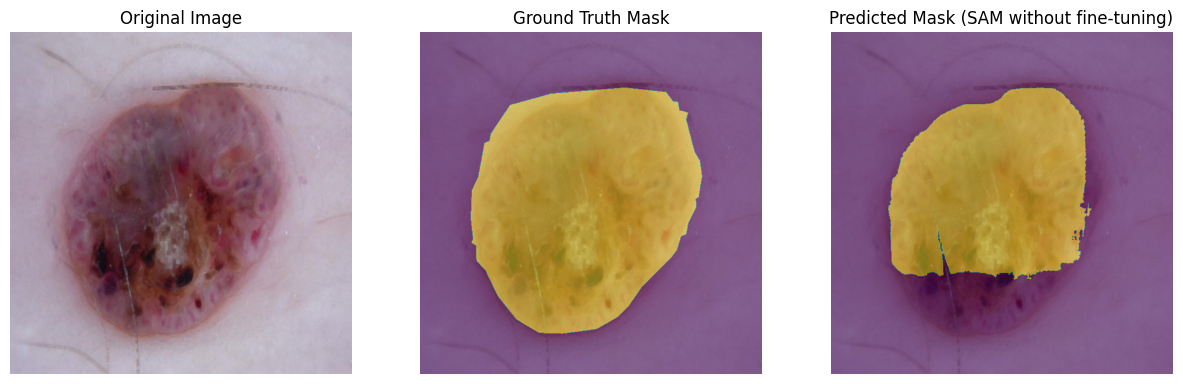

masks shape: (3, 640, 640)


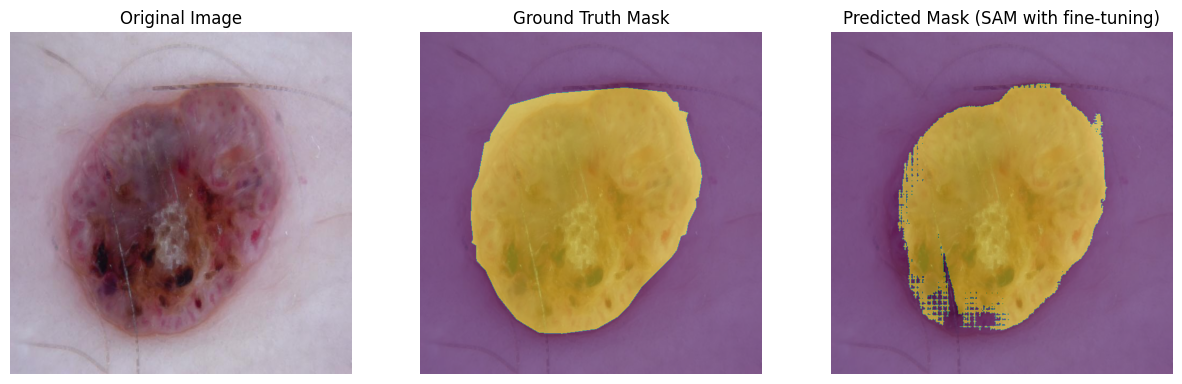

In [215]:

# Select a random image
random_img_id = random.choice(img_ids)
test_sam(sam_no_tuning,random_img_id,"SAM without fine-tuning", False)
test_sam(sam,random_img_id, "SAM with fine-tuning",False)

masks shape: (3, 640, 640)


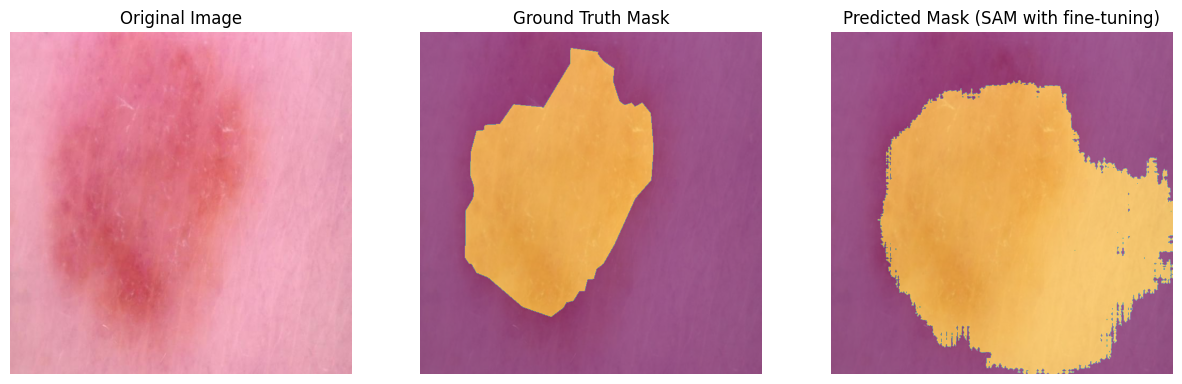

In [236]:
random_img_id = random.choice(img_ids)
test_sam(sam,random_img_id, "SAM with fine-tuning","train")